In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
hk_df = pd.read_csv ('Disney-HK.csv')
hk_df.head(5)

Unnamed: 0  Review_ID  Rating Year_Month     Reviewer_Location  \
0           0  670772142       4     2019-4             Australia   
1           1  670682799       4     2019-5           Philippines   
2           2  670623270       4     2019-4  United Arab Emirates   
3           3  670607911       4     2019-4             Australia   
4           4  670607296       4     2019-4        United Kingdom   

                                         Review_Text  Location  
0  If you've ever been to Disneyland anywhere you...  HongKong  
1  Its been a while since d last time we visit HK...  HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  HongKong  
3  HK Disneyland is a great compact park. Unfortu...  HongKong  
4  the location is not in the city, took around 1...  HongKong

First, extract reviews only

In [3]:
reviews = hk_df['Review_Text']

## Pre-processing

In [4]:
#strip ascii characters
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

#only interested in reviews written in English
def get_language(text):
    words = set(nltk.wordpunct_tokenize(text.lower()))
    lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
    if lang == 'english':
        return True
    else:
        return False

In [5]:
#change type to string
reviews = reviews.astype('str')

In [6]:
eng_rev = reviews[reviews.apply(get_language)]
eng_rev.head()
print(len(eng_rev)) #5 reviews not in english

9617


In [7]:
#remove duplicates if any
eng_rev.drop_duplicates(inplace=True)
len(eng_rev) 

9603

In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
#lemmatize
def clean_comments(text):
    #remove punctuations
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    nopunct = regex.sub(" ", str(text))
    #use spacy to lemmatize comments
    doc = nlp(nopunct, disable=['parser','ner'])
    lemmatized = [token.lemma_ for token in doc]
    return lemmatized

In [10]:
%%time 
#apply function to clean and lemmatize comments
lemm = eng_rev.map(clean_comments)

#lowercase words
lemm = lemm.map(lambda x: [word.lower() for word in x])

CPU times: user 1min 8s, sys: 7.42 s, total: 1min 15s
Wall time: 1min 16s


In [11]:
#print(type(lemm))

#need to remove space
#lemm = [x.strip(' ') for x in lemm]
lemm.head(5)

0    [if, you, ve, ever, be, to, disneyland, anywhe...
1    [its, be, a, while, since, d, last, time, we, ...
2    [thank, god, it, wasn,   , t, too, hot, or, to...
3    [hk, disneyland, be, a, great, compact, park, ...
4    [the, location, be, not, in, the, city,  , tak...
Name: Review_Text, dtype: object

In [12]:
#turn all comments' tokens into one single list
unlist_rev = [item for items in lemm for item in items]


In [13]:
#remove stopwords
stop_words = set(stopwords.words('english')) 
  
cleaned_rev = [w for w in unlist_rev if not w in stop_words] 

#remove spaces
cleaned_rev = [w for w in cleaned_rev if w != ' '] 
cleaned_rev = [w for w in cleaned_rev if w != '  '] 
cleaned_rev = [w for w in cleaned_rev if w != '   ']
#cleaned_rev

In [14]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(cleaned_rev)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(cleaned_rev)

In [15]:
bigram_freq = bigramFinder.ngram_fd.items()

In [16]:
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

In [17]:
bigramFreqTable.head(30).reset_index(drop=True)

bigram  freq
0          (hong, kong)  3107
1    (kong, disneyland)   948
2         (theme, park)   908
3          (lion, king)   903
4     (space, mountain)   810
5           (year, old)   781
6      (hk, disneyland)   748
7        (disney, park)   717
8            (one, day)   698
9   (disney, character)   617
10         (toy, story)   613
11             (2, day)   610
12  (visit, disneyland)   547
13       (main, street)   526
14       (small, world)   515
15      (mystic, manor)   509
16         (wait, time)   466
17         (make, sure)   452
18         (king, show)   444
19        (long, queue)   435
20        (ocean, park)   431
21        (story, land)   413
22   (disneyland, hong)   393
23         (fast, pass)   390
24           (go, back)   389
25           (two, day)   384
26          (day, pass)   383
27         (whole, day)   379
28     (go, disneyland)   371
29     (grizzly, gulch)   369

In [18]:
#might be more meaningful if we can get adjectives and nouns 

#function to filter for ADJ/NN bigrams

def rightTypes(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stop_words:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [19]:
#takes awhile to run
bigram_filter = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
bigram_filter.head(10)

bigram  freq
5            (hong, kong)  3107
1029   (kong, disneyland)   948
138         (theme, park)   908
550          (lion, king)   903
78      (space, mountain)   810
35       (hk, disneyland)   748
604        (disney, park)   717
461   (disney, character)   617
1333         (toy, story)   613
2850  (visit, disneyland)   547

In [20]:
test_string = bigram_filter['bigram'].tolist()
test_string[1]
#type(test_string)
#combine tuple
test_string[1][0] +'_' + test_string[1][1] 

#combine all tuples in df
bigram = [ ]
for c in range(0, len(test_string)):
    bigram.append(test_string[c][0] +'_' + test_string[c][1]) 

bigram_filter['bigram_combo'] = bigram

<ipython-input-20-1450060eecf2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigram_filter['bigram_combo'] = bigram


In [21]:
top20_bigram = bigram_filter[:20]

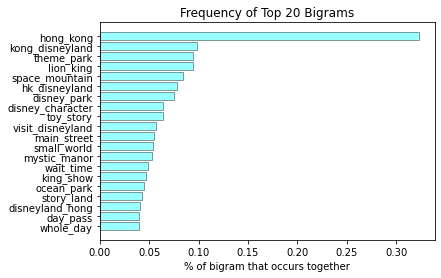

In [22]:
plt.barh(top20_bigram['bigram_combo'], top20_bigram['freq']/len(hk_df), color ='cyan', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% of bigram that occurs together")
plt.gca().invert_yaxis()
plt.title("Frequency of Top 20 Bigrams")
#plt.savefig("output\disney_hk_topbigram.jpg", bbox_inches='tight', dpi = 300)
plt.show()

### Do the same for trigrams

In [23]:
trigram_freq = trigramFinder.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
trigramFreqTable.head(5).reset_index(drop=True)

trigram  freq
0  (hong, kong, disneyland)   943
1        (lion, king, show)   439
2        (toy, story, land)   405
3  (disneyland, hong, kong)   392
4       (visit, hong, kong)   312

In [24]:
#filter NN and ADJ in trigrams
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stop_words:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False

In [25]:
trigram_filter = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]
trigram_filter.head(10)

trigram  freq
626         (lion, king, show)   439
1411        (toy, story, land)   405
4     (disneyland, hong, kong)   392
1971       (visit, hong, kong)   312
2396    (festival, lion, king)   156
685      (happy, place, earth)   155
1269  (big, grizzly, mountain)   138
555    (jungle, river, cruise)   127
6485       (spend, whole, day)   126
34     (visit, hk, disneyland)   115

In [26]:
test_string2 = trigram_filter['trigram'].tolist()

trigram = [ ]
for c in range(0, len(test_string2)):
    trigram.append(test_string2[c][0] + '_' + test_string2[c][1] + '_' + test_string2[c][2]) 

trigram_filter['trigram_combo'] = trigram
top20_trigram = trigram_filter[:20]

<ipython-input-26-d824e74f30d5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trigram_filter['trigram_combo'] = trigram


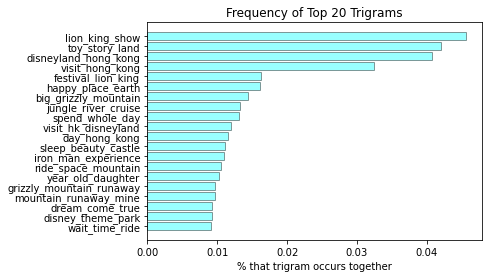

In [27]:
#plot frequency of trigram that occurs out of all ca reviews
plt.barh(top20_trigram['trigram_combo'], top20_trigram['freq']/len(hk_df), color ='cyan', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% that trigram occurs together")
plt.gca().invert_yaxis()
#plt.ylabel("Counts")
plt.title("Frequency of Top 20 Trigrams")
#plt.savefig("output\disney_hk_toptrigram.jpg", bbox_inches='tight', dpi = 300)
plt.show()

- Trigram shows a lot more! Which rides/attractions they went to, what kind of tickets they purchased, duration of stay/visit
    1. Anaheim - many talk about fast passes, waiting times, rides, type of ticket
        - "happiest place on earth!" (does this mean that reviews about ca are more subjective than other locations?)
    2. Paris - got info about disney hotel, rides, not as much fast pass or talking about being in line, characters, type of ticket, extra magic hour
    3. HK - 
- Compare what visitors are saying about rides from each park; 
    1. Anaheim - space_mountain, indiana_jones, splash_mountain, small_world
    2. Paris - space_mountain, (big) thunder_mountain, small_world, peter pan, sleeping beauty
    3. HK -

#### Next, do latent senmantic analysis (vader), and find similarities between documents by which terms appear; dimensionality reduction. Last week's lesson is a precursor to topic modeling

Next, sentiment analysis of Disney reviews can help us understand how visitors feel when they visit Disneyland -- for example, how they are responding to long lines and attractions

## Now, find reviews where top n ngram is used and analyze sentiment/emotions about rides, park experience

In [28]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def detect_tb_polarity(text):
    return TextBlob(text).sentiment.polarity
def detect_tb_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def detect_vader_pos(text):
    return vader.polarity_scores(text)['pos']

def detect_vader_neg(text):
    return vader.polarity_scores(text)['neg']

def detect_vader_comp(text):
    return vader.polarity_scores(text)['compound']

In [29]:
#ca_sample = ca_df[0:1000].copy()
hk_df['tb_polarity'] = hk_df.Review_Text.apply(detect_tb_polarity)
hk_df['tb_subjectivity'] = hk_df.Review_Text.apply(detect_tb_subjectivity)

vader = SentimentIntensityAnalyzer()
hk_df['vader_pos'] = hk_df.Review_Text.apply(detect_vader_pos)
hk_df['vader_neg'] = hk_df.Review_Text.apply(detect_vader_neg)
hk_df['vader_comp'] = hk_df.Review_Text.apply(detect_vader_comp)

In [30]:
hk_df.head()

Unnamed: 0  Review_ID  Rating Year_Month     Reviewer_Location  \
0           0  670772142       4     2019-4             Australia   
1           1  670682799       4     2019-5           Philippines   
2           2  670623270       4     2019-4  United Arab Emirates   
3           3  670607911       4     2019-4             Australia   
4           4  670607296       4     2019-4        United Kingdom   

                                         Review_Text  Location  tb_polarity  \
0  If you've ever been to Disneyland anywhere you...  HongKong     0.243981   
1  Its been a while since d last time we visit HK...  HongKong     0.236131   
2  Thanks God it wasn   t too hot or too humid wh...  HongKong     0.160498   
3  HK Disneyland is a great compact park. Unfortu...  HongKong     0.189286   
4  the location is not in the city, took around 1...  HongKong     0.266667   

   tb_subjectivity  vader_pos  vader_neg  vader_comp  
0         0.561481      0.109      0.000      0.7069  
1         0.434649      0.195      0.044      0.9853  
2         0.422944      0.220      0.022      0.9920  
3         0.512143      0.154      0.078      0.8425  
4         0.437500      0.098      0.000      0.2846

In [31]:
#assign sentiment based on compound score
hk_df['sentiment'] = ""
for y in range(0,len(hk_df)):
    if hk_df['vader_comp'][y] >= 0.05:
        hk_df['sentiment'][y] = 'positive'
    #if hk_df['vader_comp'][y] > -0.05 & hk_df['vader_comp'][y] < 0.05:
    #    hk_df['sentiment'][y] = 'neutral' 
    else:
        hk_df['sentiment'][y] = 'negative'  

<ipython-input-31-b9ce5e75379d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_df['sentiment'][y] = 'positive'
<ipython-input-31-b9ce5e75379d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_df['sentiment'][y] = 'negative'


In [32]:
hk_df['sentiment'].value_counts()

positive    8725
negative     895
Name: sentiment, dtype: int64

In [33]:
hk_df.drop('Review_ID', axis=1, inplace = True)
hk_df.drop('Unnamed: 0', axis=1, inplace = True)

In [34]:
hk_df = hk_df[hk_df['Year_Month'] != "missing"]
hk_df['year'] = pd.DatetimeIndex(hk_df['Year_Month']).year
#type(ca_1['year'])

hk_df['year'] = pd.to_numeric(hk_df['year'])
hk_df.head(10)

Rating Year_Month     Reviewer_Location  \
0       4     2019-4             Australia   
1       4     2019-5           Philippines   
2       4     2019-4  United Arab Emirates   
3       4     2019-4             Australia   
4       4     2019-4        United Kingdom   
5       3     2019-4             Singapore   
6       5     2019-4                 India   
7       3     2019-3              Malaysia   
8       2     2019-4             Australia   
9       5     2019-3                 India   

                                         Review_Text  Location  tb_polarity  \
0  If you've ever been to Disneyland anywhere you...  HongKong     0.243981   
1  Its been a while since d last time we visit HK...  HongKong     0.236131   
2  Thanks God it wasn   t too hot or too humid wh...  HongKong     0.160498   
3  HK Disneyland is a great compact park. Unfortu...  HongKong     0.189286   
4  the location is not in the city, took around 1...  HongKong     0.266667   
5  Have been to Disney World, Disneyland Anaheim ...  HongKong    -0.065476   
6  Great place! Your day will go by and you won't...  HongKong     0.185000   
7  Think of it as an intro to Disney magic for th...  HongKong     0.054722   
8  Feel so let down with this place,the Disneylan...  HongKong    -0.067284   
9  I can go on talking about Disneyland. Whatever...  HongKong     0.204497   

   tb_subjectivity  vader_pos  vader_neg  vader_comp sentiment  year  
0         0.561481      0.109      0.000      0.7069  positive  2019  
1         0.434649      0.195      0.044      0.9853  positive  2019  
2         0.422944      0.220      0.022      0.9920  positive  2019  
3         0.512143      0.154      0.078      0.8425  positive  2019  
4         0.437500      0.098      0.000      0.2846  positive  2019  
5         0.610397      0.154      0.088      0.9311  positive  2019  
6         0.590000      0.220      0.087      0.7489  positive  2019  
7         0.500556      0.109      0.030      0.8345  positive  2019  
8         0.482099      0.095      0.074      0.5195  positive  2019  
9         0.394974      0.152      0.041      0.9434  positive  2019

In [35]:
# labeling the data
rating = hk_df["vader_comp"]
def label_func(rating):
    if rating >=0.05:
        return "Positive"
    elif (rating >=0.4) & (rating <= 0.65):
            return "Neutral"
    else:
        return "Negative"
        
hk_df["Sentiment"] = hk_df["vader_comp"].apply(lambda x: label_func(x))   

In [36]:
hk_df.head(2)

Rating Year_Month Reviewer_Location  \
0       4     2019-4         Australia   
1       4     2019-5       Philippines   

                                         Review_Text  Location  tb_polarity  \
0  If you've ever been to Disneyland anywhere you...  HongKong     0.243981   
1  Its been a while since d last time we visit HK...  HongKong     0.236131   

   tb_subjectivity  vader_pos  vader_neg  vader_comp sentiment  year Sentiment  
0         0.561481      0.109      0.000      0.7069  positive  2019  Positive  
1         0.434649      0.195      0.044      0.9853  positive  2019  Positive

## Keyword Matching - "Happiest Place on Earth"

In [37]:
specific_words = ['happiest place', 'happiest place on earth']

query = '|'.join(specific_words)

hk_df['query_match'] = hk_df['Review_Text'].str.lower().str.contains(query)

In [38]:
matches = hk_df[(hk_df['query_match'] == True)]
matches.shape

(198, 14)

In [39]:
df_like = hk_df[(hk_df['query_match'] == True) & (hk_df['Sentiment'] == 'Positive')]
df_like

Rating Year_Month Reviewer_Location  \
1          4     2019-5       Philippines   
13         5     2019-4       Philippines   
157        4     2019-3         Australia   
198        5     2018-5         Indonesia   
205        5     2019-2       Philippines   
...      ...        ...               ...   
8880       4     2012-1     United States   
8884       4     2012-3       New Zealand   
8982       5     2012-2         Australia   
9201       4     2011-4       Philippines   
9298       2    2011-10     United States   

                                            Review_Text  Location  \
1     Its been a while since d last time we visit HK...  HongKong   
13    It was indeed the happiest place on earth! My ...  HongKong   
157   Firstly, it   s Disneyland. It   s the happies...  HongKong   
198   No doubt people keep saying this is the happie...  HongKong   
205   It is definitely the happiest place on earth. ...  HongKong   
...                                                 ...       ...   
8880  There's a special connecting train that you ha...  HongKong   
8884  This was our first Disneyland experience. And,...  HongKong   
8982  This was our second visit to Hong Kong Disneyl...  HongKong   
9201  We truly enjoyed our visit to Hong Kong Disney...  HongKong   
9298  Disneyland   happiest place on earth? Well HK ...  HongKong   

      tb_polarity  tb_subjectivity  vader_pos  vader_neg  vader_comp  \
1        0.236131         0.434649      0.195      0.044      0.9853   
13       0.462500         0.600000      0.295      0.000      0.8547   
157      0.112698         0.386905      0.100      0.042      0.8247   
198      0.455357         0.640873      0.229      0.000      0.9914   
205      0.380000         0.685556      0.191      0.000      0.9393   
...           ...              ...        ...        ...         ...   
8880     0.392460         0.707937      0.149      0.000      0.9748   
8884     0.297500         0.486667      0.285      0.000      0.9538   
8982     0.228610         0.611378      0.169      0.029      0.9738   
9201     0.241875         0.521389      0.183      0.022      0.9960   
9298    -0.005099         0.501909      0.080      0.028      0.9148   

     sentiment  year Sentiment  query_match  
1     positive  2019  Positive         True  
13    positive  2019  Positive         True  
157   positive  2019  Positive         True  
198   positive  2018  Positive         True  
205   positive  2019  Positive         True  
...        ...   ...       ...          ...  
8880  positive  2012  Positive         True  
8884  positive  2012  Positive         True  
8982  positive  2012  Positive         True  
9201  positive  2011  Positive         True  
9298  positive  2011  Positive         True  

[191 rows x 14 columns]

## Plotting to see how polar of these positive or negative reviews are

<AxesSubplot:xlabel='tb_polarity', ylabel='Density'>

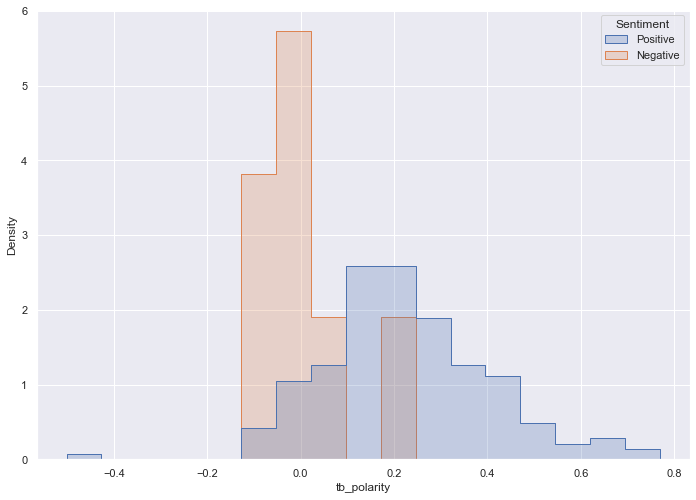

In [40]:
# the size of A4 paper
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(
    matches, x="tb_polarity", hue="Sentiment", element="step",
    stat="density", common_norm=False,
)

### Polarity of reviews on happiest place on earth:  people who have negative things to say also have higher polarity than the one that have positive things to say. Linking back to the reviews, we can say that people who holds negative opinions on it are more harsh in their reviews because they came in with higher expectations and ended up having a unsatisfied/ dismatched experience.  

## Plotting to see how subjective of these positive or negative reviews are 

<AxesSubplot:xlabel='tb_subjectivity', ylabel='Density'>

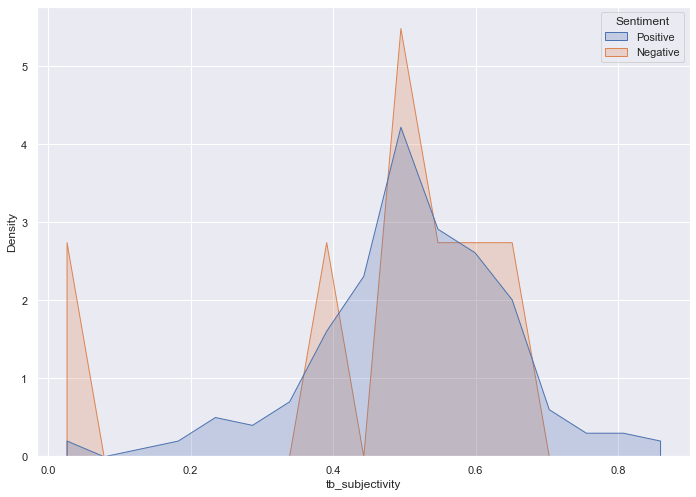

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(
    matches, x="tb_subjectivity", hue="Sentiment", element="poly",
    stat="density", common_norm=False,
)

### Seems like people who have positive things to say are more subjective in their reviews than those some of the naysayers !

In [42]:
reviews_like = df_like['Review_Text']

In [43]:
all_sentences2 = []

for word in reviews_like:
    all_sentences2.append(word)

all_sentences2

["Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironman .. Great feature n so Exciting, especially d whole scenery of HK (HK central area to Kowloon)!Antman .. Changed by previous Buzz lightyear! More or less d same, but I'm expecting to have something most!!However, my boys like it!!Space Mountain .. Turns into Star Wars!! This 1 is Great!!!For cast members (staffs) .. Felt bit MINUS point from before!!! Just dun feel like its a Disney brand!! Seems more local like Ocean Park or even worst!!They got no SMILING face, but just wanna u to enter n attraction n leave!!Hello this is supposed to be Happiest Place on Earth brand!! But, just really Dont feel it!!Bakery in Main Street now have more attractive delicacies n Disney theme sweets .. These are Good Points!!Last, they also have Starbucks now inside the theme park!!",
 "It was indeed the happi

## plot a wordcloud to see what people are talking about

In [44]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    

In [45]:
tags = reviews_like.map(lambda x:x.lower().split('|')).values
splt_tags = ' '.join(reviews_like)

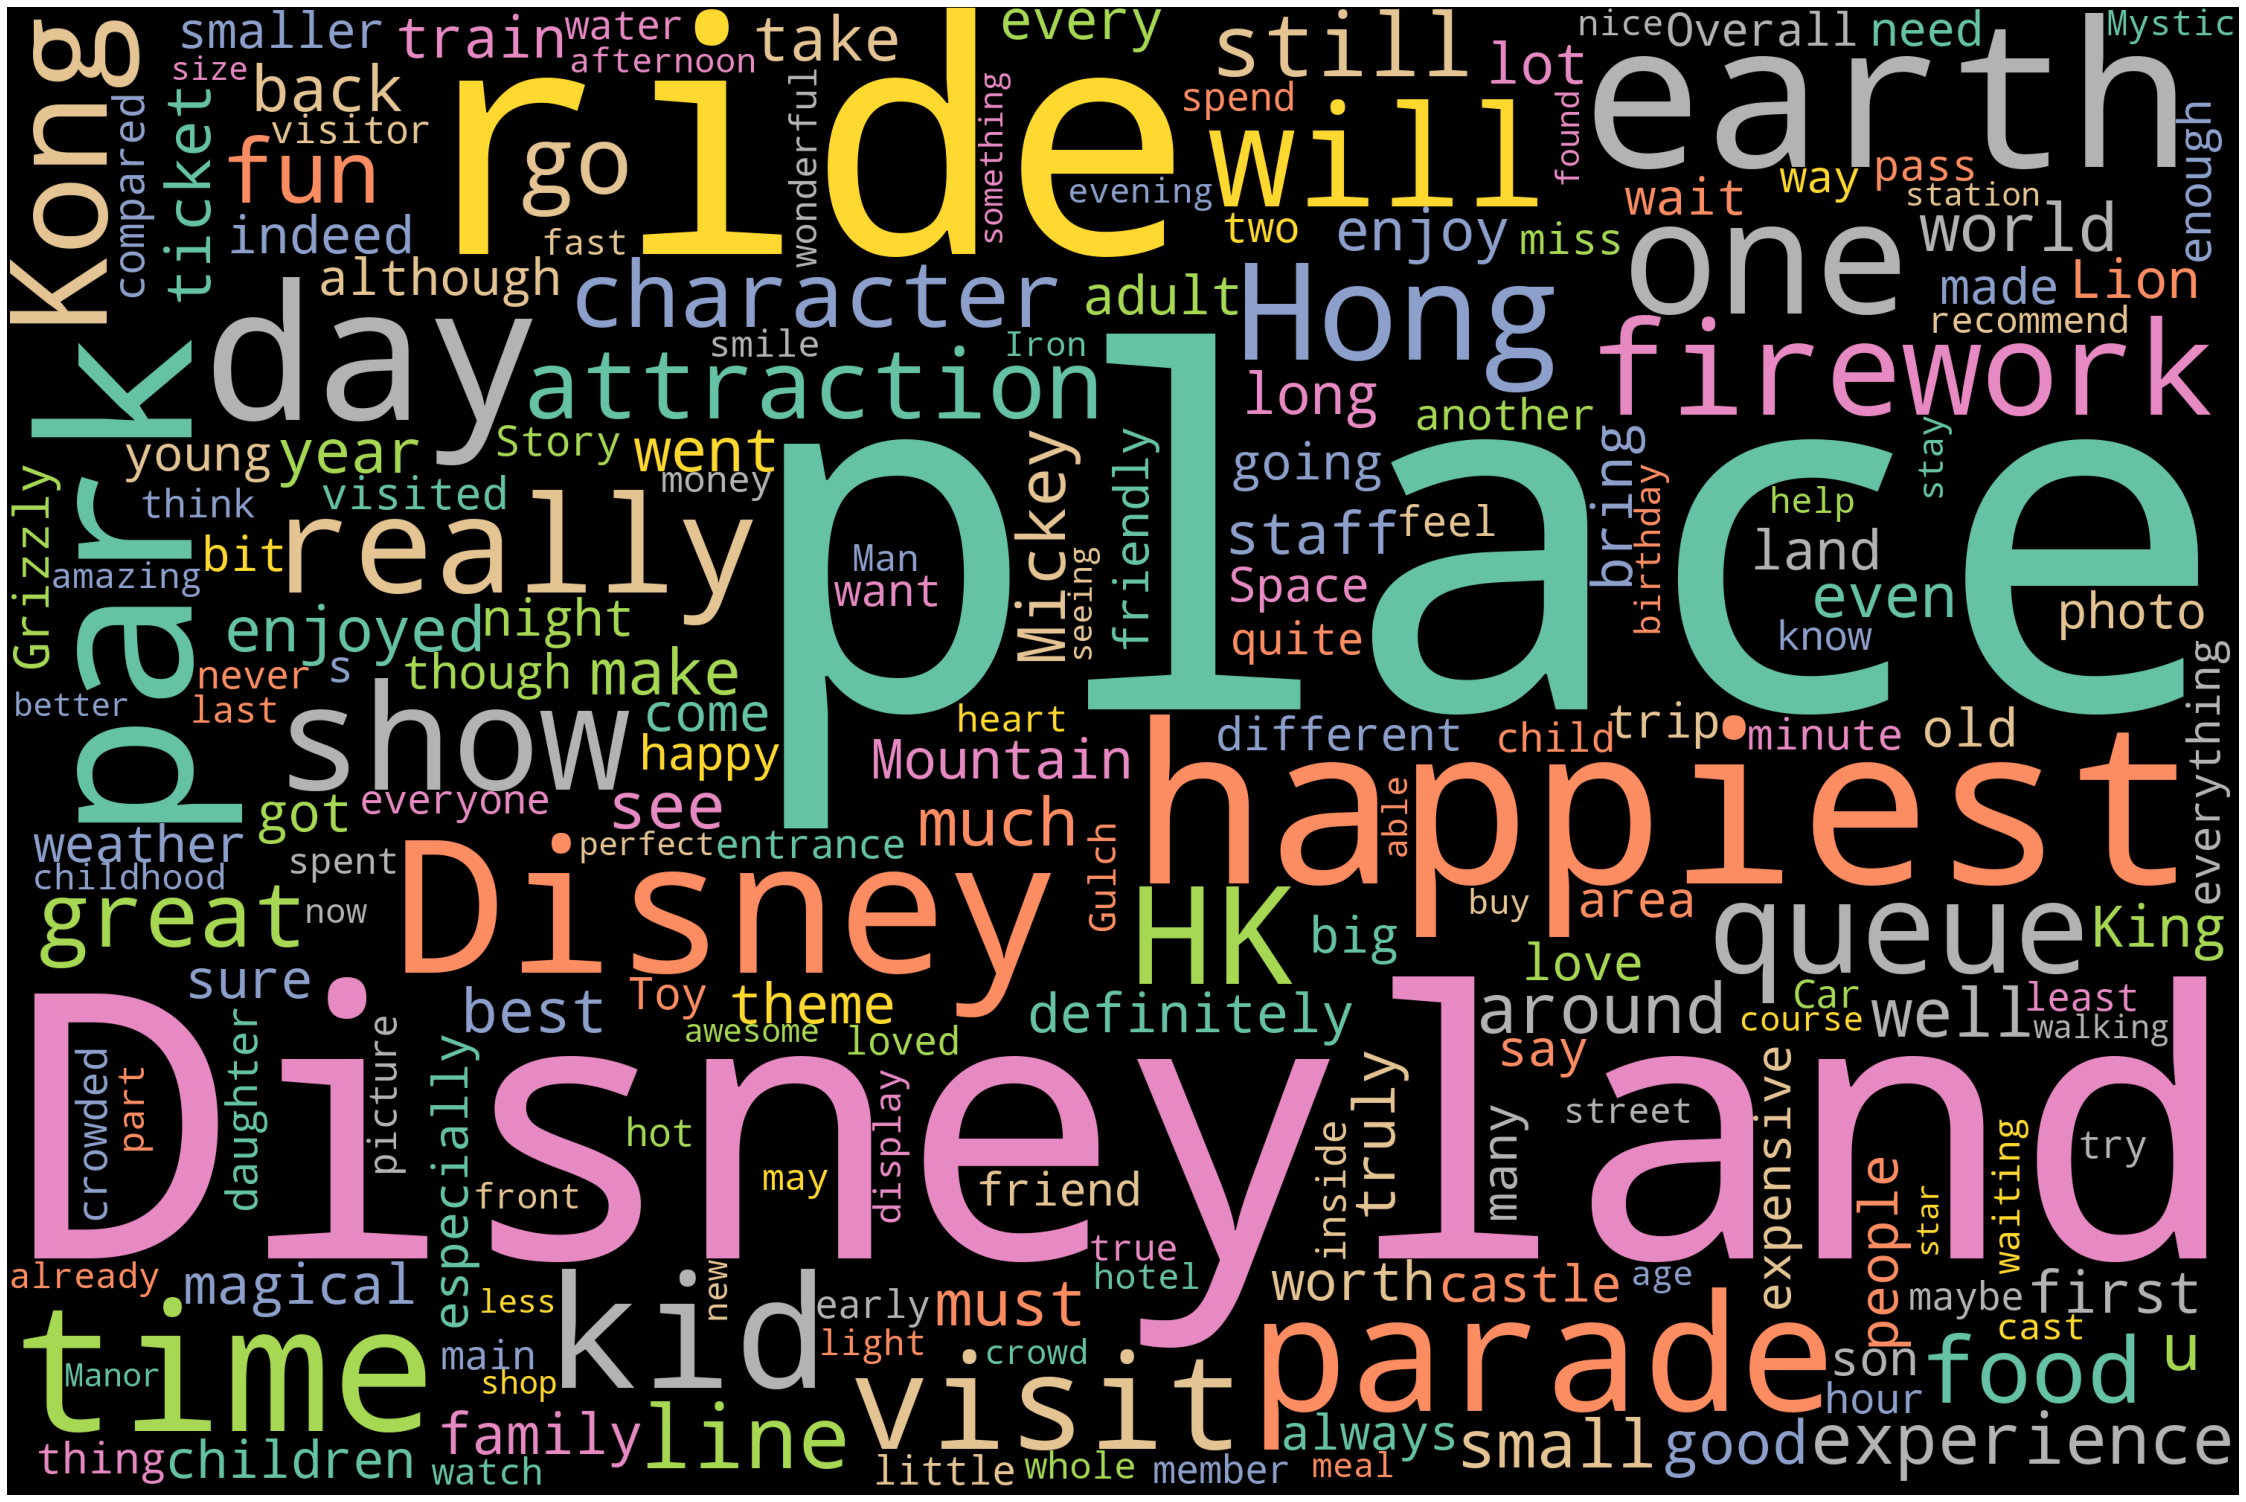

In [230]:
wordcloud = WordCloud(width = 3000, height = 2000, 
                      random_state=1, background_color='black', 
                      colormap='Set2', collocations=False, 
                      stopwords = STOPWORDS).generate(' '.join(splt_tags.split('|')))
# Plot
plot_cloud(wordcloud)

In [46]:
lines = list()
for line in all_sentences2:    
    words = line.split()
    for w in words: 
        lines.append(w) 

In [47]:
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]

lines

lines2 = []

for word in lines:
    if word != '':
        lines2.append(word)

In [48]:
stem = []
for word in lines2:
    stem.append(s_stemmer.stem(word))

NameError: name 's_stemmer' is not defined

In [50]:
stem2 = []
for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)

In [49]:
df = pd.DataFrame(stem2)
df = df[0].value_counts()
df = df[:20,]

NameError: name 'stem2' is not defined

In [220]:
str1 = " " 
stem2 = str1.join(lines2)

stem2 = nlp(stem2)

label = [(X.text, X.label_) for X in stem2.ents]

df2 = pd.DataFrame(label, columns = ['Word','Entity'])

In [221]:
df2['Entity'].value_counts()
pos = df2.groupby(['Entity']).size().to_frame('count').reset_index()
pos.sort_values(by='count', ascending=False)[:10]

Entity  count
9        ORG    230
1       DATE    165
3        FAC    147
4        GPE    141
0   CARDINAL    134
10    PERSON    112
13      TIME     62
6        LOC     60
8    ORDINAL     44
7       NORP     19

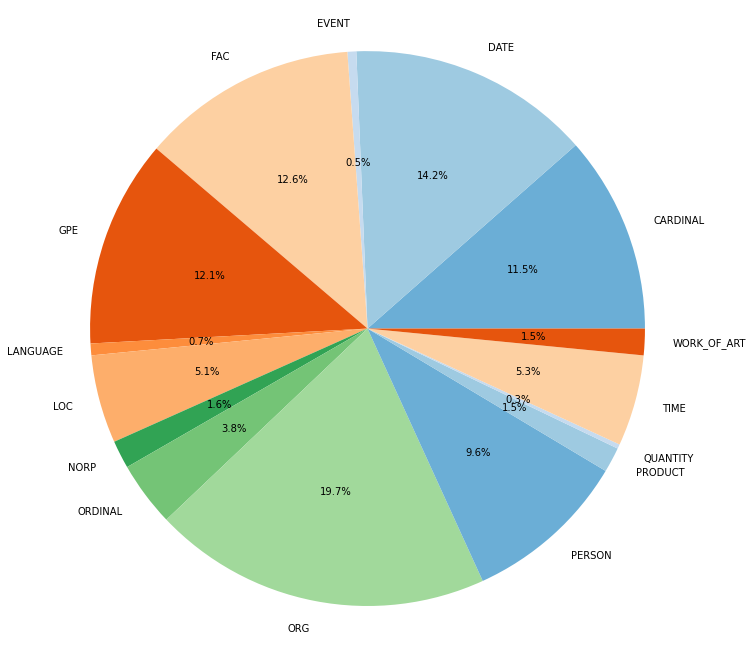

In [254]:
fig = plt.figure(figsize=(17,9))
ax = fig.add_axes((0,0,.5,1))
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 3, 7, 4, 5, 6,8, 9, 10]))
ax.pie(pos['count'],colors = inner_colors, labels= pos['Entity'], autopct='%1.1f%%')
ax.axis('equal')
plt.show()

### I was trying to see the subject of people reviews? Like if for fast pass, people's reviews talk about time more. But it seems in "happiest place on earth" there is no definitive insight - I can't try to extract much insight out of it

## Keyword Matching - "Fast Pass"

## This one:

In [169]:
specific_words = ['fast pass']

query = '|'.join(specific_words)

hk_df['query_match'] = hk_df['Review_Text'].str.lower().str.contains(query)
# hk_df['word matched'] = hk_df['Review_Text'].str.extract( '({})'.format(query) )

hk_df.head(5)

<ipython-input-169-2c3b2968a6d1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df['query_match'] = ca_df['Review_Text'].str.lower().str.contains(query)


Unnamed: 0  Review_ID  Rating Year_Month     Reviewer_Location  \
0           0  670772142       4     2019-4             Australia   
1           1  670682799       4     2019-5           Philippines   
2           2  670623270       4     2019-4  United Arab Emirates   
3           3  670607911       4     2019-4             Australia   
4           4  670607296       4     2019-4        United Kingdom   

                                         Review_Text  Location  tb_polarity  \
0  If you've ever been to Disneyland anywhere you...  HongKong     0.243981   
1  Its been a while since d last time we visit HK...  HongKong     0.236131   
2  Thanks God it wasn   t too hot or too humid wh...  HongKong     0.160498   
3  HK Disneyland is a great compact park. Unfortu...  HongKong     0.189286   
4  the location is not in the city, took around 1...  HongKong     0.266667   

   tb_subjectivity  vader_pos  vader_neg  vader_comp  year  query_match  \
0         0.561481      0.109      0.000      0.7069  2019        False   
1         0.434649      0.195      0.044      0.9853  2019        False   
2         0.422944      0.220      0.022      0.9920  2019        False   
3         0.512143      0.154      0.078      0.8425  2019        False   
4         0.437500      0.098      0.000      0.2846  2019        False   

  word matched Sentiment  
0          NaN  Positive  
1          NaN  Positive  
2          NaN  Positive  
3          NaN  Positive  
4          NaN  Positive

In [57]:
matches2 = hk_df[(hk_df['query_match'] == True)]
matches2 

Rating Year_Month Reviewer_Location  \
1          4     2019-5       Philippines   
13         5     2019-4       Philippines   
157        4     2019-3         Australia   
198        5     2018-5         Indonesia   
205        5     2019-2       Philippines   
...      ...        ...               ...   
8880       4     2012-1     United States   
8884       4     2012-3       New Zealand   
8982       5     2012-2         Australia   
9201       4     2011-4       Philippines   
9298       2    2011-10     United States   

                                            Review_Text  Location  \
1     Its been a while since d last time we visit HK...  HongKong   
13    It was indeed the happiest place on earth! My ...  HongKong   
157   Firstly, it   s Disneyland. It   s the happies...  HongKong   
198   No doubt people keep saying this is the happie...  HongKong   
205   It is definitely the happiest place on earth. ...  HongKong   
...                                                 ...       ...   
8880  There's a special connecting train that you ha...  HongKong   
8884  This was our first Disneyland experience. And,...  HongKong   
8982  This was our second visit to Hong Kong Disneyl...  HongKong   
9201  We truly enjoyed our visit to Hong Kong Disney...  HongKong   
9298  Disneyland   happiest place on earth? Well HK ...  HongKong   

      tb_polarity  tb_subjectivity  vader_pos  vader_neg  vader_comp  \
1        0.236131         0.434649      0.195      0.044      0.9853   
13       0.462500         0.600000      0.295      0.000      0.8547   
157      0.112698         0.386905      0.100      0.042      0.8247   
198      0.455357         0.640873      0.229      0.000      0.9914   
205      0.380000         0.685556      0.191      0.000      0.9393   
...           ...              ...        ...        ...         ...   
8880     0.392460         0.707937      0.149      0.000      0.9748   
8884     0.297500         0.486667      0.285      0.000      0.9538   
8982     0.228610         0.611378      0.169      0.029      0.9738   
9201     0.241875         0.521389      0.183      0.022      0.9960   
9298    -0.005099         0.501909      0.080      0.028      0.9148   

     sentiment  year Sentiment  query_match  
1     positive  2019  Positive         True  
13    positive  2019  Positive         True  
157   positive  2019  Positive         True  
198   positive  2018  Positive         True  
205   positive  2019  Positive         True  
...        ...   ...       ...          ...  
8880  positive  2012  Positive         True  
8884  positive  2012  Positive         True  
8982  positive  2012  Positive         True  
9201  positive  2011  Positive         True  
9298  positive  2011  Positive         True  

[198 rows x 14 columns]

## Plotting to see how polar of these positive or negative reviews are

<AxesSubplot:xlabel='tb_polarity', ylabel='Density'>

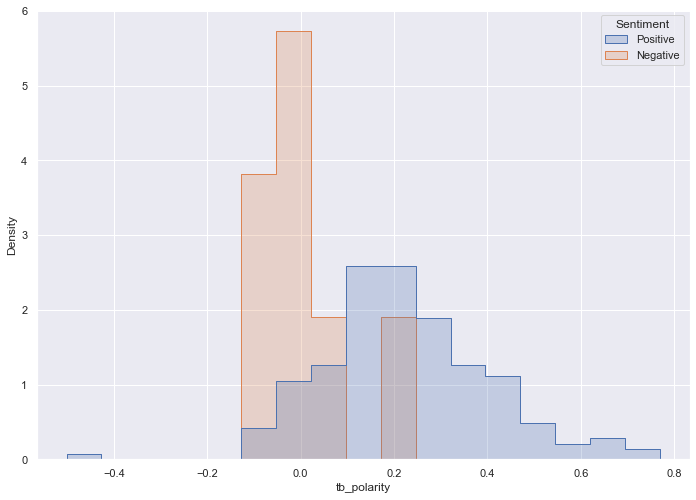

In [58]:
# the size of A4 paper
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(
    matches2, x="tb_polarity", hue="Sentiment", element="step",
    stat="density", common_norm=False,
)

### Since we are looking at fast pass, the ones that are more negative reviews that have high polarity, this means that people who are unhappy in these reviews are really grumpy.

## plotting to see how subjective of these positive or negative reviews are 

<AxesSubplot:xlabel='tb_subjectivity', ylabel='Density'>

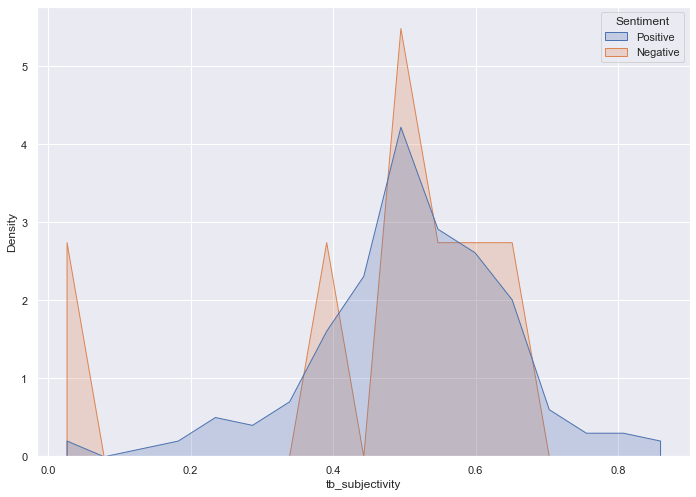

In [59]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(
    matches2, x="tb_subjectivity", hue="Sentiment", element="poly",
    stat="density", common_norm=False,
)

### It seems people who are really grumpy about fast pass are also subjective in reviews! In other words, they aren't just venting without considering the facts!

## Speeach Tagging 

In [61]:
df_dislike = hk_df[(hk_df['query_match'] == True) & (hk_df['Sentiment'] == 'Negative')]
df_dislike.shape

(7, 14)

In [62]:
review_dislike = df_dislike['Review_Text']

In [63]:
all_sentences = []

for word in review_dislike:
    all_sentences.append(word)

all_sentences

['Full of Mainland tourists, spitting and pushing and shoving. IS NOT THE HAPPIEST PLACE ON EARTH!!! Expensive!!',
 "As expected of Disney their rides and facilities were top notch, but it was such a dissapointment that the service was not up to that standed.I am aware that Hong Kong culture can come across as being unfreindly, but I expected a lot more of the Disney staff. They were exeedingly unhelpful and made my family and I feel very unwelcome, it wouldn't hurt them to so much as try putting on a smile. Such a shame that the  Happiest place on earth  had the saddest people.",
 'Disneyland is the Happiest Place except for buying souvenirs and stuffs . But I can say that this place will make you make you want to be a child again . A place that you should not skip on visiting while you   re in Hong Kong. This is my 2nd time to visit but still I can   t get enough of it. The experience of singing with the casts while they are dancing and you dancing and swaying with them. And that fee

## plotting another word cloud

In [64]:
tags2 = review_dislike.map(lambda x:x.lower().split('|')).values
splt_tags2 = ' '.join(review_dislike)

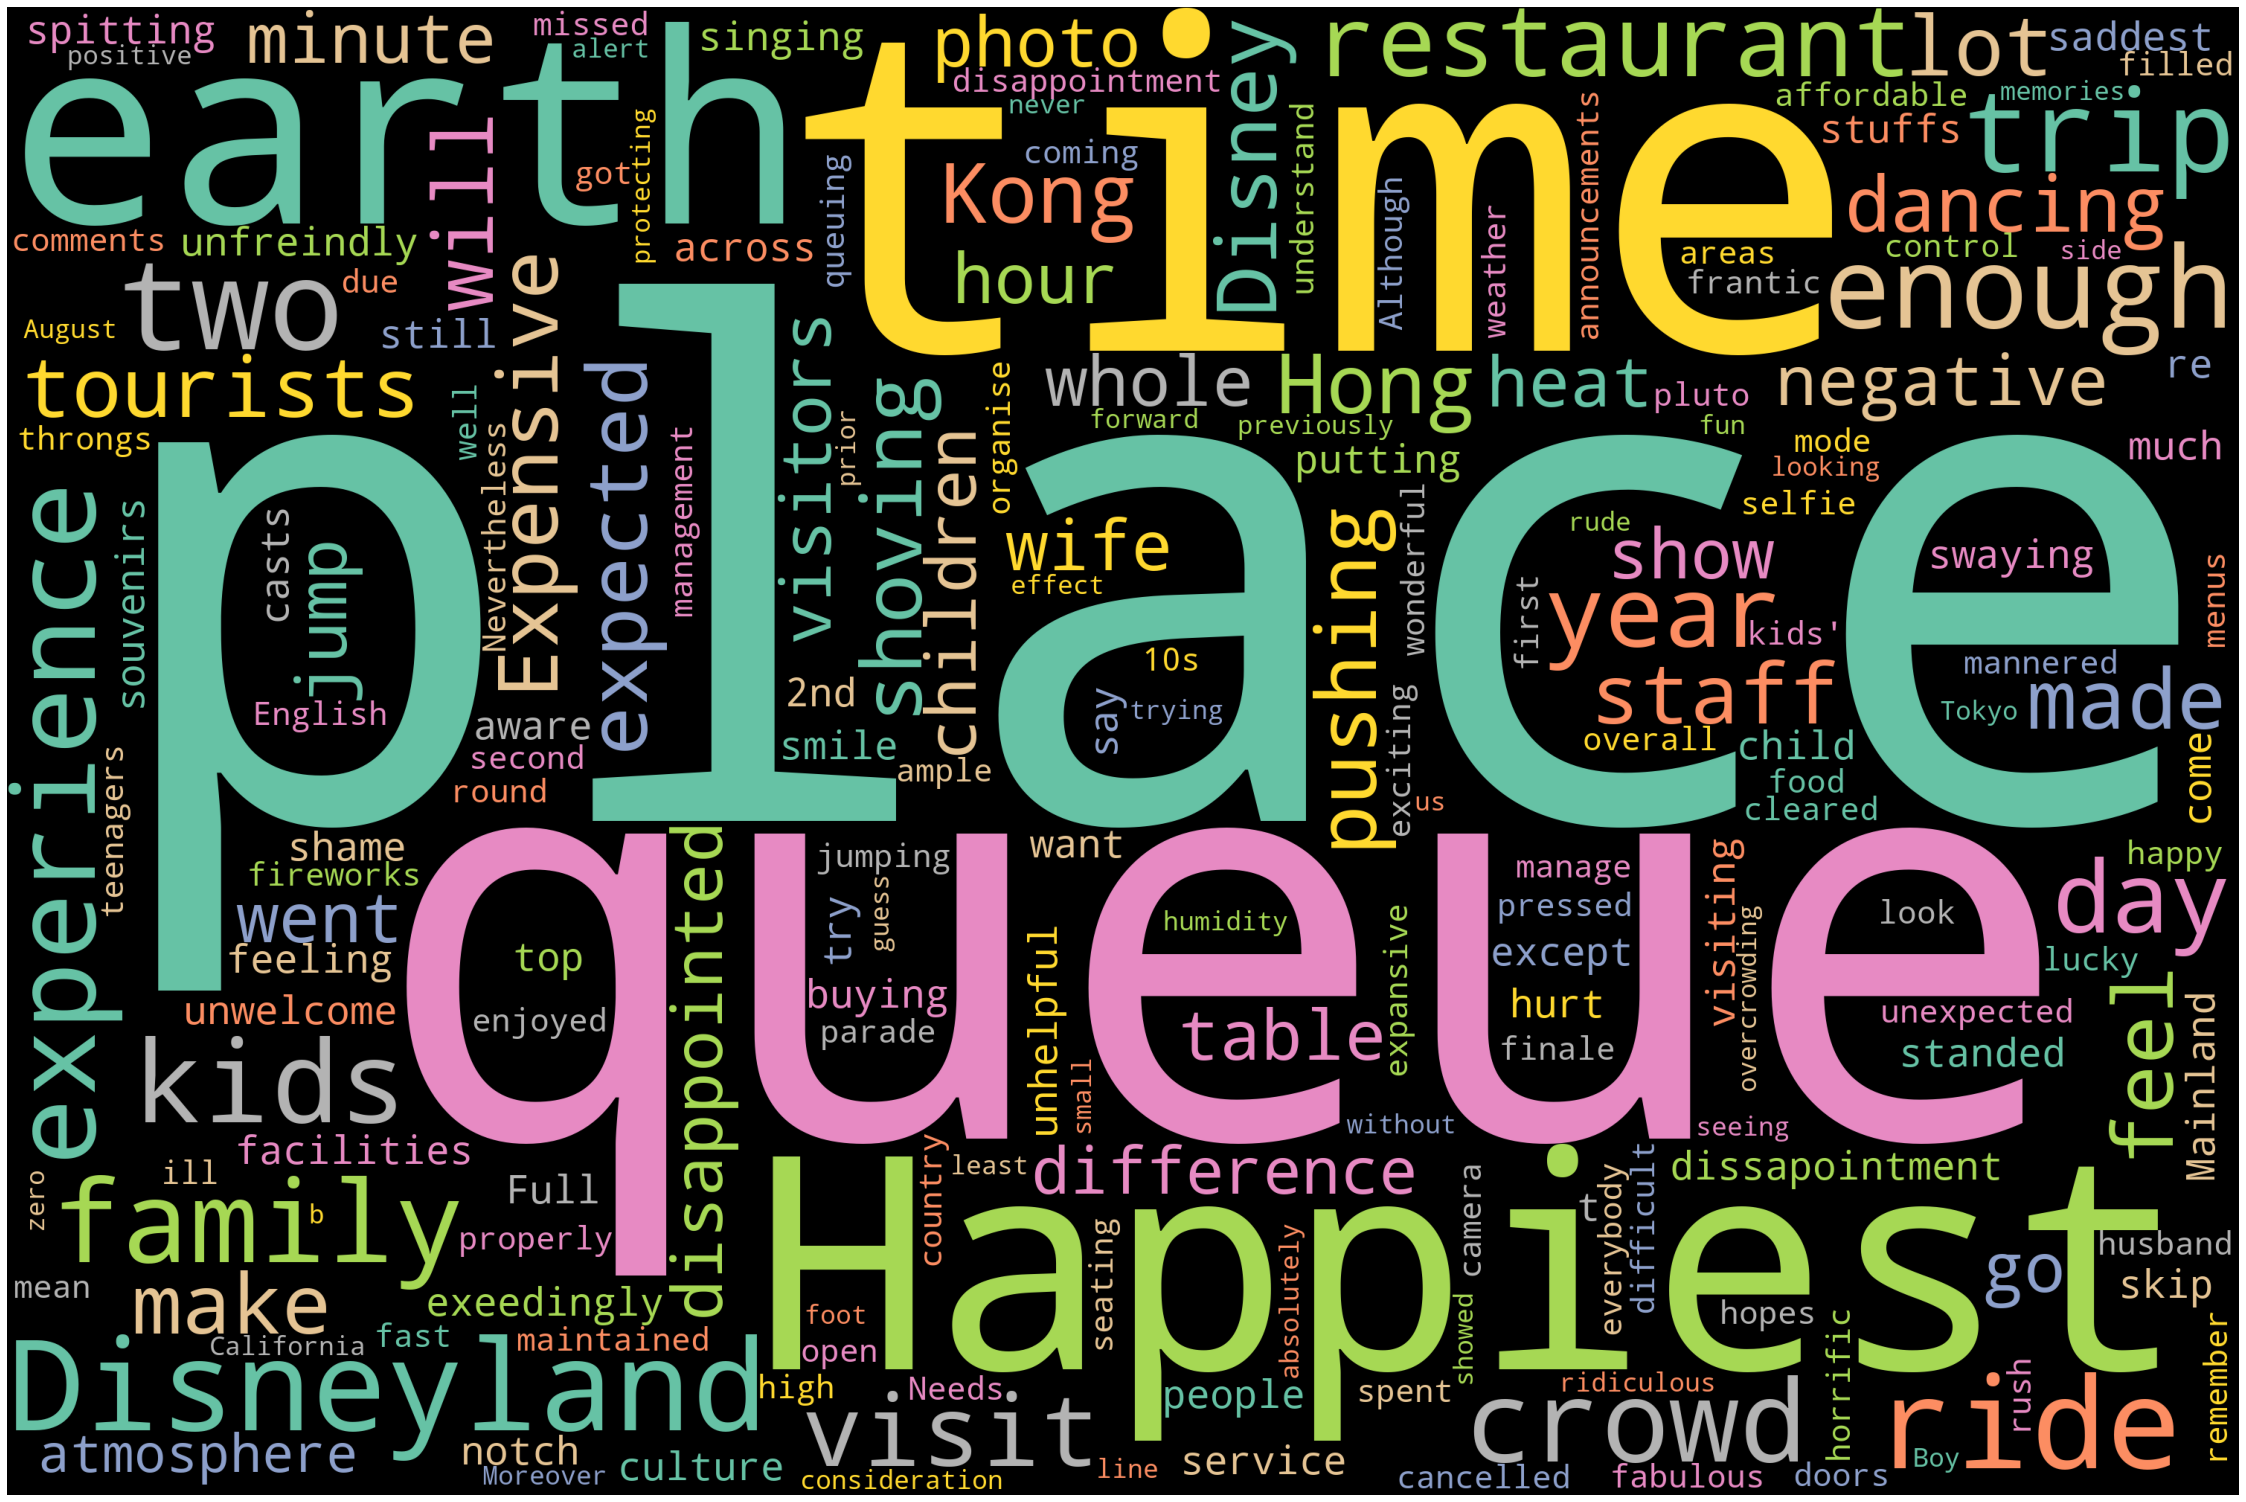

In [65]:
wordcloud2 = WordCloud(width = 3000, height = 2000, 
                      random_state=1, background_color='black', 
                      colormap='Set2', collocations=False, 
                      stopwords = STOPWORDS).generate(' '.join(splt_tags2.split('|')))
# Plot
plot_cloud(wordcloud2)

In [67]:
from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english')

stem = []
for word in lines2:
    stem.append(s_stemmer.stem(word))

In [68]:
lines = list()
for line in all_sentences:    
    words = line.split()
    for w in words: 
        lines.append(w) 

In [69]:
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]

lines

['Full',
 'of',
 'Mainland',
 'tourists',
 'spitting',
 'and',
 'pushing',
 'and',
 'shoving',
 'IS',
 'NOT',
 'THE',
 'HAPPIEST',
 'PLACE',
 'ON',
 'EARTH',
 'Expensive',
 'As',
 'expected',
 'of',
 'Disney',
 'their',
 'rides',
 'and',
 'facilities',
 'were',
 'top',
 'notch',
 'but',
 'it',
 'was',
 'such',
 'a',
 'dissapointment',
 'that',
 'the',
 'service',
 'was',
 'not',
 'up',
 'to',
 'that',
 'standedI',
 'am',
 'aware',
 'that',
 'Hong',
 'Kong',
 'culture',
 'can',
 'come',
 'across',
 'as',
 'being',
 'unfreindly',
 'but',
 'I',
 'expected',
 'a',
 'lot',
 'more',
 'of',
 'the',
 'Disney',
 'staff',
 'They',
 'were',
 'exeedingly',
 'unhelpful',
 'and',
 'made',
 'my',
 'family',
 'and',
 'I',
 'feel',
 'very',
 'unwelcome',
 'it',
 'wouldnt',
 'hurt',
 'them',
 'to',
 'so',
 'much',
 'as',
 'try',
 'putting',
 'on',
 'a',
 'smile',
 'Such',
 'a',
 'shame',
 'that',
 'the',
 'Happiest',
 'place',
 'on',
 'earth',
 'had',
 'the',
 'saddest',
 'people',
 'Disneyland',
 'is',

In [70]:
lines2 = []

for word in lines:
    if word != '':
        lines2.append(word)

In [71]:
from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english')

stem = []
for word in lines2:
    stem.append(s_stemmer.stem(word))

In [72]:
#import spacy
#spacy.cli.download('en_core_web_lg')

In [73]:
nlp = spacy.load('en_core_web_lg')
stem2 = []

In [74]:
for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)

In [75]:
df = pd.DataFrame(stem2)
df = df[0].value_counts()
df = df[:20,]

In [76]:
#== 
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
#====== 
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text + ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label_)))
#======
nlp = spacy.load('en_core_web_sm') 
nlp.max_length = 2000000000000

In [77]:
#=====
str1 = " " 
stem2 = str1.join(lines2)

stem2 = nlp(stem2)

label = [(X.text, X.label_) for X in stem2.ents]

df2 = pd.DataFrame(label, columns = ['Word','Entity'])

In [78]:
df2

Word    Entity
0                Disney       ORG
1             Hong Kong       GPE
2                Disney       ORG
3            Disneyland       FAC
4             Hong Kong       GPE
5                   2nd   ORDINAL
6                   10s      DATE
7                    14  CARDINAL
8                     2  CARDINAL
9                second   ORDINAL
10               only 3  CARDINAL
11              English  LANGUAGE
12                first   ORDINAL
13                  two  CARDINAL
14           Disneyland       FAC
15                Tokyo       GPE
16           California       GPE
17  at least 45 minutes      TIME
18      just a 2 minute      TIME
19                 zero  CARDINAL
20     the time of year      DATE
21               August      DATE
22               summer      DATE
23                  two  CARDINAL
24      about two hours      TIME
25    4 and 3 years old      DATE
26                  two  CARDINAL
27             two days      DATE
28              an hour      TIME
29           Disneyland       FAC
30             the year      DATE
31         a school day      DATE
32          Los Angeles       GPE
33           Disneyland       FAC
34                   LA       GPE
35                Earth       LOC

In [81]:
df2['Entity'].value_counts()
negative = df2.groupby(['Entity']).size().to_frame('count').reset_index()
negative.sort_values(by='count', ascending=False)[:10]

Entity  count
1      DATE      8
0  CARDINAL      7
3       GPE      6
2       FAC      4
8      TIME      4
6   ORDINAL      3
7       ORG      2
4  LANGUAGE      1
5       LOC      1

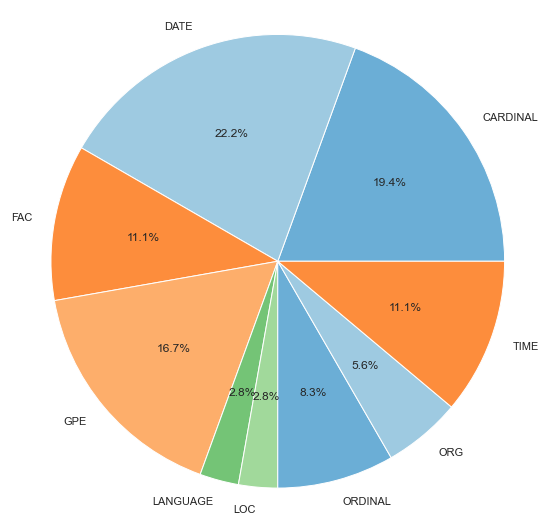

In [82]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes((0,0,.5,1))
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))
ax.pie(negative['count'],colors = inner_colors, labels= negative['Entity'], autopct='%1.1f%%')
ax.axis('equal')
plt.show()

## for fast pass related reviews, it seems naturally people are talking about date and time more in these reviews than compare to "happiest place on earth"

## Keyword Matching - "Small World"

In [83]:
specific_words = ['small world']

query = '|'.join(specific_words)

hk_df['query_match'] = hk_df['Review_Text'].str.lower().str.contains(query)
# hk_df['word matched'] = hk_df['Review_Text'].str.extract( '({})'.format(query) )

hk_df.head(5)

Rating Year_Month     Reviewer_Location  \
0       4     2019-4             Australia   
1       4     2019-5           Philippines   
2       4     2019-4  United Arab Emirates   
3       4     2019-4             Australia   
4       4     2019-4        United Kingdom   

                                         Review_Text  Location  tb_polarity  \
0  If you've ever been to Disneyland anywhere you...  HongKong     0.243981   
1  Its been a while since d last time we visit HK...  HongKong     0.236131   
2  Thanks God it wasn   t too hot or too humid wh...  HongKong     0.160498   
3  HK Disneyland is a great compact park. Unfortu...  HongKong     0.189286   
4  the location is not in the city, took around 1...  HongKong     0.266667   

   tb_subjectivity  vader_pos  vader_neg  vader_comp sentiment  year  \
0         0.561481      0.109      0.000      0.7069  positive  2019   
1         0.434649      0.195      0.044      0.9853  positive  2019   
2         0.422944      0.220      0.022      0.9920  positive  2019   
3         0.512143      0.154      0.078      0.8425  positive  2019   
4         0.437500      0.098      0.000      0.2846  positive  2019   

  Sentiment  query_match  
0  Positive         True  
1  Positive        False  
2  Positive        False  
3  Positive        False  
4  Positive        False

In [84]:
matches3 = hk_df[(hk_df['query_match'] == True)]
matches3 

Rating Year_Month Reviewer_Location  \
0          4     2019-4         Australia   
90         5     2019-4    United Kingdom   
121        5     2019-2             China   
208        4     2019-2         Singapore   
218        4     2019-1     United States   
...      ...        ...               ...   
9359       3     2011-7     United States   
9365       5     2011-6          Malaysia   
9382       4     2011-6         Singapore   
9416       5     2011-3     United States   
9420       3    2010-11          Thailand   

                                            Review_Text  Location  \
0     If you've ever been to Disneyland anywhere you...  HongKong   
90    Buy your discounted tickets on Klook (thus no ...  HongKong   
121   Without a doubt, a true Disney experience.The ...  HongKong   
208   A wholesome place to take the kids. Only gripe...  HongKong   
218   It was fun to go to HK Disneyland. We stayed a...  HongKong   
...                                                 ...       ...   
9359  I know... I know... I get it... We are America...  HongKong   
9365  Regardless how many times I visited Disneyland...  HongKong   
9382  Disney lovers should visit Hong Kong Disneylan...  HongKong   
9416  Disneyland Hong Kong really impressed me and m...  HongKong   
9420  If you want to go to the most small Disneyland...  HongKong   

      tb_polarity  tb_subjectivity  vader_pos  vader_neg  vader_comp  \
0        0.243981         0.561481      0.109      0.000      0.7069   
90       0.125054         0.543441      0.097      0.063      0.8758   
121      0.149242         0.583838      0.145      0.044      0.8847   
208      0.142500         0.467500      0.092      0.035      0.5574   
218      0.152193         0.387281      0.093      0.024      0.9047   
...           ...              ...        ...        ...         ...   
9359     0.089974         0.461979      0.059      0.039      0.7115   
9365     0.158033         0.488948      0.184      0.030      0.9993   
9382     0.375149         0.597024      0.268      0.000      0.9974   
9416     0.239412         0.526818      0.191      0.032      0.9983   
9420    -0.016667         0.316667      0.126      0.000      0.7474   

     sentiment  year Sentiment  query_match  
0     positive  2019  Positive         True  
90    positive  2019  Positive         True  
121   positive  2019  Positive         True  
208   positive  2019  Positive         True  
218   positive  2019  Positive         True  
...        ...   ...       ...          ...  
9359  positive  2011  Positive         True  
9365  positive  2011  Positive         True  
9382  positive  2011  Positive         True  
9416  positive  2011  Positive         True  
9420  positive  2010  Positive         True  

[450 rows x 14 columns]

## Plotting to see how polar of these positive or negative reviews are

<AxesSubplot:xlabel='tb_polarity', ylabel='Density'>

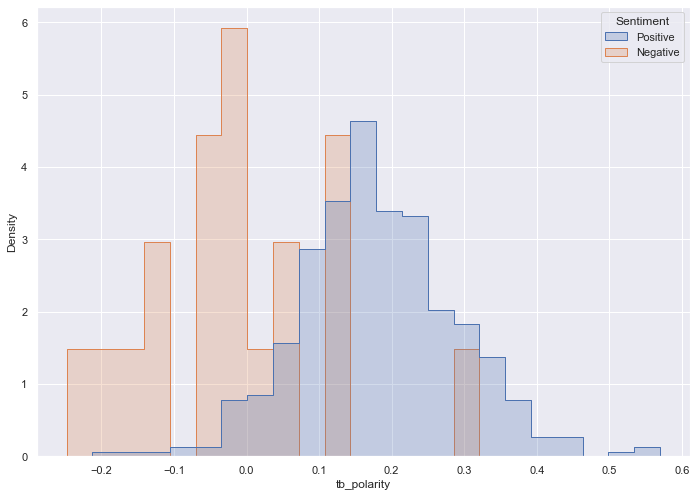

In [87]:
# the size of A4 paper
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(
    matches3, x="tb_polarity", hue="Sentiment", element="step",
    stat="density", common_norm=False,
)

## plotting to see how subjective of these positive or negative reviews are 

<AxesSubplot:xlabel='tb_subjectivity', ylabel='Density'>

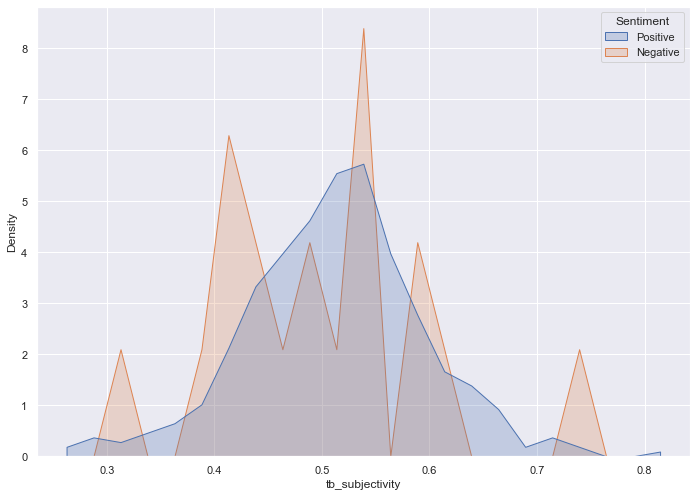

In [88]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(
    matches3, x="tb_subjectivity", hue="Sentiment", element="poly",
    stat="density", common_norm=False,
)

In [95]:
mtc_dislike = matches3[matches3['Sentiment'] == 'Negative']

Rating Year_Month Reviewer_Location  \
899        3     2018-6         Hong Kong   
1727       4    2017-10     United States   
1807       3     2017-9     United States   
1910       4     2017-8       Philippines   
2232       5     2017-3     United States   
2823       1    2016-12         Hong Kong   
2869       4     2017-1            Canada   
4117       4     2016-1       Philippines   
4635       4     2016-2          Malaysia   
4795       3     2016-1         Australia   
5086       4    2015-11    United Kingdom   
6262       1     2014-8    United Kingdom   
6289       3     2015-1         Hong Kong   
6653       1    2014-10         Australia   
7154       3     2014-5         Hong Kong   
7264       5     2013-5       Philippines   
9039       2     2012-1     United States   
9332       1     2011-8         Indonesia   
9333       2     2011-8     United States   

                                            Review_Text  Location  \
899   I hate to give Disney a bad review but I have ...  HongKong   
1727  I have visited 4 Disney parks so far and Hong ...  HongKong   
1807  Maybe September is not a big month for Disney ...  HongKong   
1910  The visit to Disneyland was the visit that was...  HongKong   
2232  This Disney is a smaller version of the other ...  HongKong   
2823  My young daughter loves Hong Kong Disneyland s...  HongKong   
2869  We were here in early January after the public...  HongKong   
4117   Too bad the small world area is closed that t...  HongKong   
4635  This is the first time where from opening from...  HongKong   
4795  It's for young families  it's tired meaning a ...  HongKong   
5086  Visited on a Monday afternoon so queues were m...  HongKong   
6262  This was my first time going to a disneyland a...  HongKong   
6289  As an Ex patriot living in Hong Kong for many ...  HongKong   
6653  I am so glad that I have been lucky enough to ...  HongKong   
7154  Not a great amusement park, but has a few good...  HongKong   
7264  This may be the smallest Disneyland but it is ...  HongKong   
9039  HK Disneyland has a typical disneyland layout ...  HongKong   
9332  Don't get me wrong, I don't mind to visit a sm...  HongKong   
9333  This is patterned on the original Disneyland w...  HongKong   

      tb_polarity  tb_subjectivity  vader_pos  vader_neg  vader_comp  \
899     -0.027217         0.547487      0.094      0.093     -0.2259   
1727     0.038235         0.399066      0.052      0.106     -0.9023   
1807     0.028386         0.480495      0.090      0.090     -0.0245   
1910    -0.191667         0.523148      0.055      0.151     -0.8720   
2232     0.119848         0.465606      0.070      0.082     -0.0214   
2823    -0.015100         0.480898      0.088      0.165     -0.9981   
2869    -0.110880         0.442824      0.035      0.120     -0.7351   
4117    -0.065625         0.545833      0.104      0.111     -0.1022   
4635     0.000000         0.577778      0.000      0.000      0.0000   
4795    -0.167500         0.420000      0.000      0.160     -0.6734   
5086    -0.069444         0.733333      0.043      0.043      0.0000   
6262    -0.127278         0.549556      0.043      0.054     -0.5714   
6289     0.129449         0.400558      0.053      0.043     -0.4016   
6653    -0.049583         0.543889      0.090      0.080     -0.0013   
7154     0.135185         0.420370      0.133      0.177     -0.1414   
7264     0.291667         0.620833      0.060      0.082     -0.1650   
9039    -0.010023         0.310256      0.022      0.156     -0.9366   
9332    -0.248077         0.588462      0.070      0.093     -0.3899   
9333     0.046032         0.450661      0.062      0.079     -0.6768   

     sentiment  year Sentiment  query_match  
899   negative  2018  Negative         True  
1727  negative  2017  Negative         True  
1807  negative  2017  Negative         True  
1910  negative  2017  Negative         True  
2232  negative  2017  Negative         True  
2823  n

In [ ]:
## plotting another word cloud

In [96]:
tags3 = mtc_dislike.map(lambda x:x.lower().split('|')).values
splt_tags3 = ' '.join(mtc_dislike)

AttributeError: 'DataFrame' object has no attribute 'map'

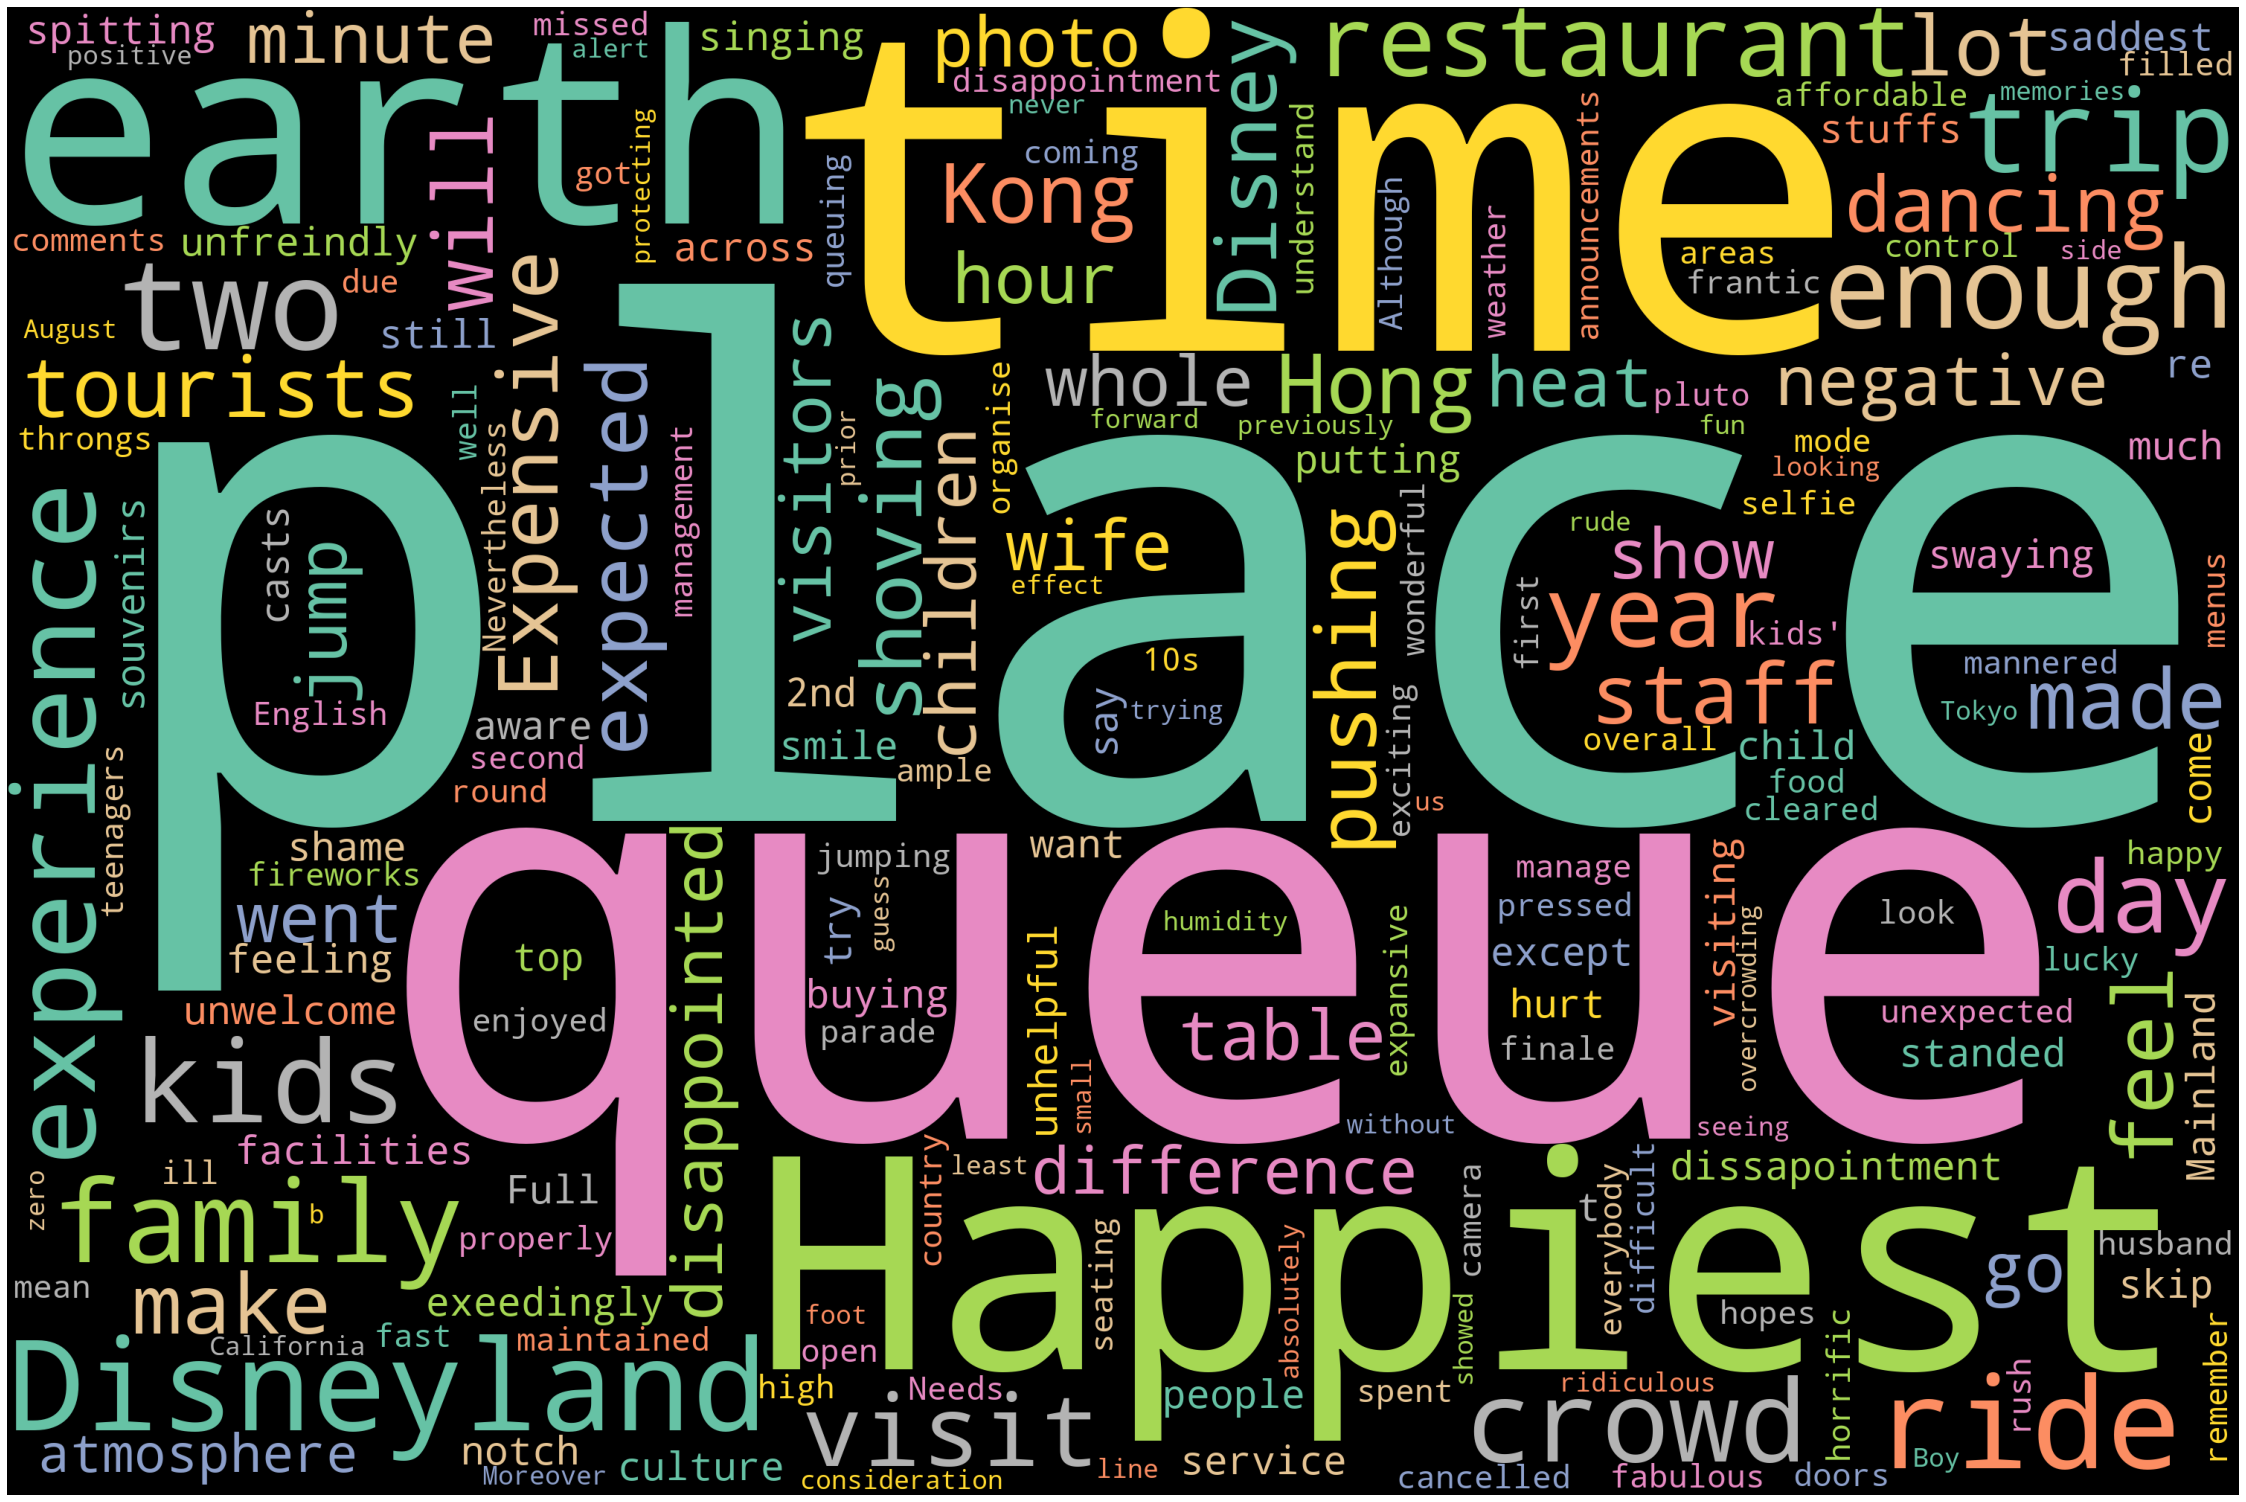

In [91]:
wordcloud3 = WordCloud(width = 3000, height = 2000, 
                      random_state=1, background_color='black', 
                      colormap='Set2', collocations=False, 
                      stopwords = STOPWORDS).generate(' '.join(splt_tags3.split('|')))
# Plot
plot_cloud(wordcloud3)